In [1]:
############# SUPPORT VECTOR MACHINE (Gamman) ############### impotring Librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
#from sklearn.cross_validation import train_test_split
#import sklearn.metrics.plot_roc_curve


In [2]:
#importing data

print('The scikit-learn version is {}.'.format(sklearn.__version__))
############# REMEMBER TO PUT YOUR PATH HERE ###############
df = pd.read_excel(r'wellMa1.xlsx')#.sample(n=2500)
#dfb = pd.read_excel(r'well4fit.xlsx').sample(n=500)
#df = pd.concat([dfa, dfb], sort=False)
#print(df)

facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD']
labels = ['Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti', 'Dolomia e anidrite']
labels2 = ['Argilloscisti', 'Dolomia e anidrite']
labelsdfa = ['Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti']
df = df.dropna() 

# First step - remove the NULL values
df.shape # Shape the dataset
#dfa.shape
#dropcol = ['Depth', 'Litologia', 'Litologia Code']

The scikit-learn version is 0.22.1.


(42377, 7)

In [3]:
#df.head(200)

# Plotting Curve


In [4]:
def my_plot_values(logs, facies_colors):
    
    ### The logs will be the dataset (df) information that we passes
    logs = logs.sort_values(by='Depth')
    
    # Build the colormap
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    # Create the cluster we will plot
    cluster = np.repeat(np.expand_dims(logs['Litologia_Code'].values,1), 100, 1)
    
    # plot the bars and assign for each bar a different information (Gamma Ray, Spontaneous Potential, Neutron Porosity)
    f, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (8, 12))
    ax[0].plot(logs.Gamma_Ray, logs.Depth, '-g')
    ax[1].plot(logs.Spontaneous_Potential, logs.Depth, '-')
    ax[2].plot(logs.Neutron_Porosity, logs.Depth, '-', color = '0.5')
    
    # Here we will show the bar cluster with all the information and colormap legend
    im = ax[3].imshow(cluster, interpolation = 'none', aspect = 'auto', cmap = cmap_facies, vmin = 1, vmax = 9)
    
    ### Here we plot the "divider" which is the little bar showed next to the last bar (with colormap legend)
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size = "20%", pad = 0.05)
    cbar = plt.colorbar(im, cax = cax)
    #cbar.set_label((17*' ').join(['Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti', 'Dolomia e anidrite']))
    cbar.set_label((17*' ').join(['ARG', 'DCA', 'DOL', 'CCDOL', 'MRN', 'CC', 'ARLLE']))
    cbar.set_ticks(range(0,1))
    cbar.set_ticklabels('')
    
    ### Here we will plot the little lines inside each bar
    for i in range(len(ax)-1):
        ax[i].set_ylim(logs.Depth.min(),logs.Depth.max())
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis = 'x', nbins = 3)
    
    
    ### Here we will put the names of each bar and set the x limits
    ax[0].set_xlabel("Gamma Ray")
    ax[0].set_xlim(logs.Gamma_Ray.min(),logs.Gamma_Ray.max())
    ax[1].set_xlabel("Spontaneous Potential")
    ax[1].set_xlim(logs.Spontaneous_Potential.min(),logs.Spontaneous_Potential.max())
    ax[2].set_xlabel("Neutron Porosity")
    ax[2].set_xlim(logs.Neutron_Porosity.min(),logs.Neutron_Porosity.max())
    ax[3].set_xlabel("Litologia")
    
    ### Here we set the y-tick labes for each bar
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])

In [5]:
###### LEGEND OF THE WELL ######

df1 = df[df['Well_name'] == '01_VILLADEGNA1.']


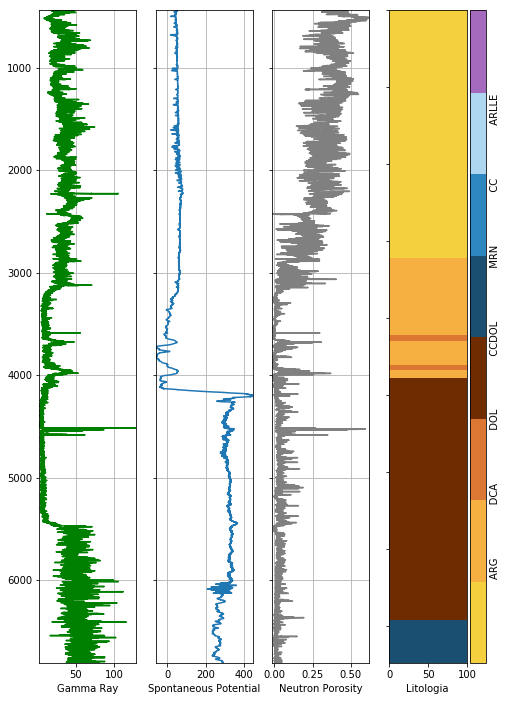

In [6]:
my_plot_values(df1, facies_colors)

1 - Argille
2 - Calcari
3 - Marne
4 - Calcari dolomitizzati
5 - Dolomie
6 - Dolomie calcaree e anidriti
7 - Argilloscisti
8 - Dolomia e anidrite


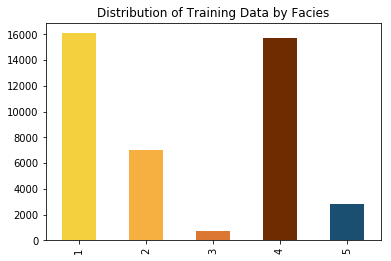

In [7]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df['Litologia_Code'].value_counts().sort_index()
#use facies labels to index each count
#facies_counts.index = labels
print("1 - Argille\n2 - Calcari\n3 - Marne\n4 - Calcari dolomitizzati\n5 - Dolomie\n6 - Dolomie calcaree e anidriti\n7 - Argilloscisti\n8 - Dolomia e anidrite")
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

# Data Filtering & Scaleling

In [8]:
X = df[['Gamma_Ray', 'Neutron_Porosity', 'Spontaneous_Potential']].values # 1 Gamma Ray, 2 Spontaneous Potential, 3 Neutron Porosity 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

features = ['Gamma_Ray', 'Neutron_Porosity', 'Spontaneous_Potential']

df_features = df[features].values
#print(df_features)


y = df.iloc[:, 6].values # Litologia_Code
y = np.array(y)
#print(y)
scaler = StandardScaler().fit(df_features)
scaler_features = scaler.transform(df_features)

#clfsc = OneVsRestClassifier(LinearSVC(random_state=0))
#scaler = StandardScaler().fit(df_features)
#scaler_features = scaler.transform(df_features)

In [9]:
#print(df)

# Traning & Tessting Algorithem

In [10]:
y_lit = df['Litologia_Code']
y_lit = y_lit.unique()
y_lit_values = df['Litologia_Code'].values
class_names = df.iloc[:, 6]
#print(class_names)

In [11]:
from sklearn.svm import SVC

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y_lit_values, test_size = 0.40)
classifier = SVC(gamma='auto',C = 1)


In [13]:
classifier.fit(X_train, y_train)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
class_names = df.iloc[:, 6]
#print(class_names)
from sklearn.utils.multiclass import unique_labels

In [16]:
labels = ['Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti', 'Dolomia e anidrite']
#labels = ['Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti']

Confusion matrix, without normalization
[[6436   61    3    7    0]
 [ 367 2381   27   56    0]
 [ 164   44   70    4    0]
 [   0   86    0 5901  208]
 [   0    0    0  308  828]]
Normalized confusion matrix
[[9.89e-01 9.37e-03 4.61e-04 1.08e-03 0.00e+00]
 [1.30e-01 8.41e-01 9.54e-03 1.98e-02 0.00e+00]
 [5.82e-01 1.56e-01 2.48e-01 1.42e-02 0.00e+00]
 [0.00e+00 1.39e-02 0.00e+00 9.53e-01 3.36e-02]
 [0.00e+00 0.00e+00 0.00e+00 2.71e-01 7.29e-01]]


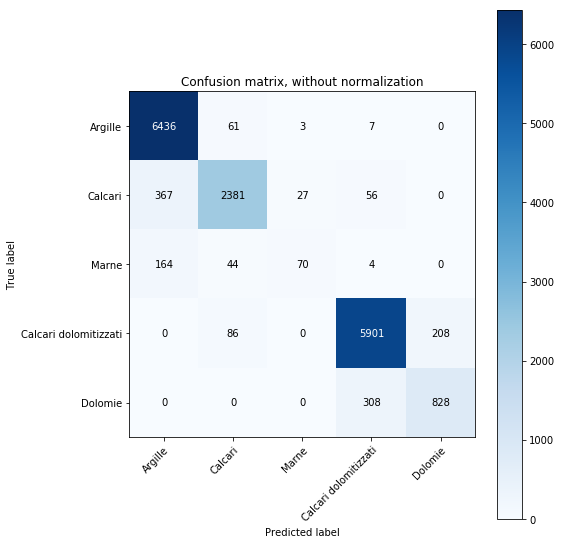

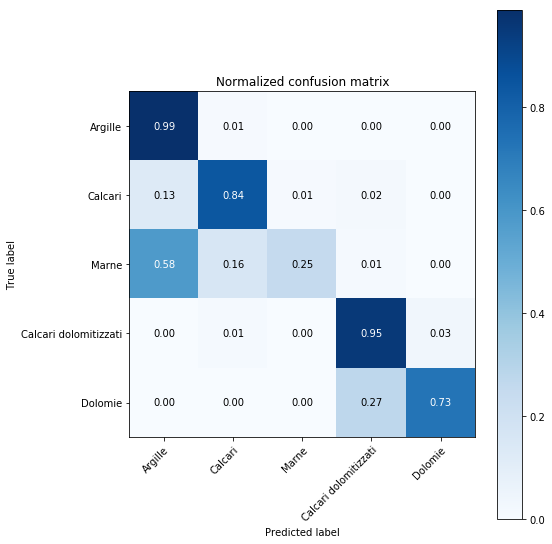

Accuracy: 0.921243584449295
[[6436   61    3    7    0]
 [ 367 2381   27   56    0]
 [ 164   44   70    4    0]
 [   0   86    0 5901  208]
 [   0    0    0  308  828]]
              precision    recall  f1-score   support

           1       0.92      0.99      0.96      6507
           2       0.93      0.84      0.88      2831
           3       0.70      0.25      0.37       282
           4       0.94      0.95      0.95      6195
           5       0.80      0.73      0.76      1136

    accuracy                           0.92     16951
   macro avg       0.86      0.75      0.78     16951
weighted avg       0.92      0.92      0.92     16951

Accuracy score y_test e y_pred: 0.921243584449295
Litologia Code = Argille: 1, Calcari: 2, Marne: 3, Calcari dolomitizzati: 4, Dolomie: 5, Dolomie calcaree e anidriti: 6, Argilloscisti: 7, Dolomia e anidrite: 8


In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    from matplotlib.pyplot import figure
    #figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect = 'equal')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    np.set_printoptions(precision=2)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confmatrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
#print(f"Accuracy score di y_test e y_pred: {accuracy_score(X_train, y_train)}")
print(f"Accuracy score y_test e y_pred: {accuracy_score(y_test, y_pred)}")

print('Litologia Code = Argille: 1, Calcari: 2, Marne: 3, Calcari dolomitizzati: 4, Dolomie: 5,', 'Dolomie calcaree e anidriti: 6,', 'Argilloscisti: 7,','Dolomia e anidrite: 8')
#'Argille', 'Calcari', 'Marne', 'Calcari dolomitizzati', 'Dolomie', 'Dolomie calcaree e anidriti', 'Argilloscisti', 'Dolomia e anidrite'

In [18]:
##END OF WELL123 Trining and testing####

In [19]:
###### LEGEND OF THE WELL ######

df1 = df[df['Well_name'] == '01_VILLADEGNA1.']
df2 = df[df['Well_name'] == '02_SAN_DONATO1.']
df3 = df[df['Well_name'] == '03_antrodoco1_1.']
df4 = df[df['Well_name'] == '04_perugia2.']

In [20]:
#my_plot_values(df1, facies_colors)

In [21]:
#my_plot_values(df2, facies_colors)

In [22]:
#my_plot_values(df3, facies_colors)

In [23]:
#my_plot_values(df4, facies_colors)

In [24]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [25]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    ##### FILTERS TO AVOID PLOTTING NaN VALUES
    #gr_value = logs['Gamma_Ray'].values
    #sp_value = logs['Spontaneous_Potential'].values
    #np_value = logs['Neutron_Porosity'].values
    
    cluster1 = np.repeat(np.expand_dims(sorted(logs['Litologia_Code'].values),1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(compadre,1), 100, 1)
    ncl = 5
    ind = 0
    number = 0
    
    ### HERE FIRST I COUNT HOW MANY VALID COLUMNS (!=0) WE HAVE 
    if(not(logs['Gamma_Ray'] == 0).all()): number+=1
    if(not(logs['Spontaneous_Potential'] == 0).all()): number+=1
    if(not(logs['Neutron_Porosity'] == 0).all()): number+=1
        
    f, ax = plt.subplots(nrows=1, ncols=number+2, figsize=(9, 12))
    if(not(logs['Gamma_Ray'] == 0).all()):
        ax[ind].plot(logs.Gamma_Ray, logs.Depth, '-g')
        ax[ind].set_xlabel("Gamma_Ray")
        ax[ind].set_xlim(logs.Gamma_Ray.min(),logs.Gamma_Ray.max())
        ind+=1
    else:
        ncl-=1
    
    if(not(logs['Spontaneous_Potential'] == 0).all()):
        ax[ind].plot(logs.Spontaneous_Potential, logs.Depth, '-')
        ax[ind].set_xlabel("Spontaneous_Potential")
        ax[ind].set_xlim(logs.Spontaneous_Potential.min(),logs.Spontaneous_Potential.max())
        ax[ind].set_yticklabels([]); 
        ind+=1
    else:
        ncl-=1
        
    
    
 
    if(not(logs['Neutron_Porosity'] == 0).all()):
        ax[ind].plot(logs.Neutron_Porosity, logs.Depth, '-', color='0.5')
        ax[ind].set_xlabel("Neutron_Porosity")
        ax[ind].set_xlim(logs.Neutron_Porosity.min(),logs.Neutron_Porosity.max())
        ax[ind].set_yticklabels([]);
        ind+=1
    else:
        ncl-=1
    
    
    im1 = ax[ind].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,
                    vmin=1.0,
                    vmax=9.0)
    ax[ind].set_xlabel('Litologia_Code')
    ax[ind].set_yticklabels([]);
    
    ind+=1
    im2 = ax[ind].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,
                    vmin=1.0,
                    vmax=9.0)
    
    ax[ind].set_xlabel('Predictions')
    ax[ind].set_yticklabels([]);
    ax[ind].set_xticklabels([]);
    divider = make_axes_locatable(ax[ind])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join(['Argil', 'Cal', 'Mar', 'CD', 'Dol', 'DC', 'Agsc', 'DeA']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
   # print(len(ax))
   # print(ncl+1)
    if((len(ax) < (ncl+1))):
        for i in range((ncl+1)-len(ax)):
            ax[i].set_ylim(ztop,zbot)
            ax[i].invert_yaxis()
            ax[i].grid()
            ax[i].locator_params(axis='x', nbins=3)
            
    else:
        for i in range(len(ax)-(ncl+1)):
            
            ax[i].set_ylim(ztop,zbot)
            ax[i].set_ylim(zbot,ztop)
            ax[i].invert_yaxis()
            ax[i].grid()
            ax[i].locator_params(axis='x', nbins=3)


In [26]:
def compare_facies_plot1234(logs, compadre, cmp, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    print(f"COLORMAP: {cmap_facies}")
    #cluster1 = np.repeat(np.expand_dims(logs['Litologia_Code'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(compadre,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(cmp, 1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(9, 12))
    ax[0].plot(logs.Gamma_Ray, logs.Depth, '-g')
    ax[1].plot(logs.Neutron_Porosity, logs.Depth, '-', color='0.5')
    
    #ax[1].plot(logs.Spontaneous_Potential, logs.Depth, '-')
    
    #im1 = ax[2].imshow(cluster1, interpolation='none', aspect='auto',
    #                cmap=cmap_facies,
    #                vmin=1.0,
    #                vmax=9.0)
    
    im3 = ax[2].imshow(cluster3, interpolation='none', aspect='auto',
                    cmap=cmap_facies,
                    vmin=1.0,
                    vmax=9.0)
    im2 = ax[3].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,
                    vmin=1.0,
                    vmax=9.0)
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im3, cax=cax)
    cbar.set_label((17*' ').join(['Argil', 'Cal', 'Mar', 'CD', 'Dol', 'DC', 'Agsc', 'DeA']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("Gamma_Ray")
    ax[0].set_xlim(logs.Gamma_Ray.min(),logs.Gamma_Ray.max())
    #ax[1].set_xlabel("Spontaneous_Potential")
    #ax[1].set_xlim(logs.Spontaneous_Potential.min(),logs.Spontaneous_Potential.max())
    ax[1].set_xlabel("Neutron_Porosity")
    ax[1].set_xlim(logs.Neutron_Porosity.min(),logs.Neutron_Porosity.max())
    
    #ax[2].set_xlabel('Litologia_Code')
    
    ax[2].set_xlabel('Predictions on Well4')
    ax[3].set_xlabel('Predictions on Well123')
    
    #ax[0].set_yticklabels([]);
    ax[1].set_yticklabels([]);
    ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([]); 
    #ax[4].set_yticklabels([]);
    
    #ax[0].set_xticklabels([]);
    #ax[1].set_xticklabels([]);
    #ax[2].set_xticklabels([]);
    #ax[3].set_xticklabels([]);
    #ax[4].set_xticklabels([]);
    #f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

# WELL123 Predictions

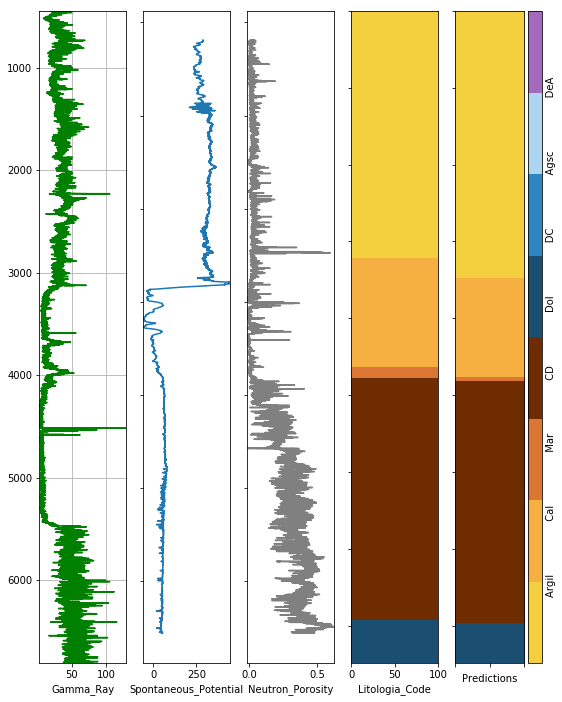

In [27]:
compare_facies_plot(df, sorted(y_pred), facies_colors)